In [9]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb

from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report

# Pipelines
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe

# Handling class imbalance
from imblearn.over_sampling import SMOTE

In [10]:
# Load churn dataset
df = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Customer-Churn-Prediction-/master/Resources/Analytical_Base_Table.csv")

# Quick overview
print(df.head())
print(df.info())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditSc

# Separating features and target

In [11]:
# Object for target variable
y = df.Exited

# object for input features
X = df.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [12]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [13]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [15]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    dff = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    dff['Count'] = dff['Count'].astype('int64')
    dff['%'] = round(dff['Count'] / a.shape[0] * 100, 2)
    return dff.sort_values('Count',ascending=False)

In [27]:
class_count(y)

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


# Create Train Test Split

In [29]:
random_state = 10

# Split X and y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=df.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


# Pre-processing Pipeline

## Scale numerical data and encode categorical data

Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder

Create lists of indexes from the list of column names

Need to be numeric not string to specify columns name in column transformer

In [33]:
num_features = []

for i in num_cols:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 3, 4, 5, 6, 7, 8, 9]


In [35]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[1, 2]


In [38]:
# Define column transformer
# Need to be numeric not string to specify columns name
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
        (OneHotEncoder(sparse_output=False), cat_features)
        )
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False), [1, 2])])

# Build Model Pipeline with SMOTE

We are going to use the Pipeline from the imblearn package in place of scikit-learn Pipeline.

It takes care automatically to re-sample when called fit() on the pipeline, and does not re-sample test data (when called transform() or predict()).

In [41]:
# Import XGBoost
import xgboost as xgb

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                                    xgb.XGBClassifier(use_label_encoder=False, random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [43]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [45]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {
    'xgbclassifier__gamma': [0.5, 0.8, 1],
    'xgbclassifier__max_depth': [3, 4, 5, 6],
    'xgbclassifier__n_estimators': [50, 100, 200]
}
grid = GridSearchCV(model, param_grid, verbose=3, cv= 5, n_jobs=4, scoring='f1_macro')

In [46]:
X_train = X_train.values
X_test = X_test.values

In [48]:
# Train the model with GridSearch
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:36:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [1,
                                                                          2])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=4,
             param_grid={'xgbclassifier__gamma': [0.5, 0.8, 1],
                         'xgbclassifier__max_depth': [3, 4, 5, 6],
                         'xgbclassifier__n_estimators': [50, 100, 200]},
             scoring='f1_macro', verbose=3)

In [49]:
print(grid.best_params_)

{'xgbclassifier__gamma': 0.8, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 100}


In [50]:
 # List the best score
 print(grid.best_score_)

0.7612982384579798


In [51]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.8106322732916824
Testing Data Score: 0.766781181961393


In [52]:
# Make predictions with the hypertuned model
pred = grid.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, pred)
print(cm)

[[2187  202]
 [ 241  370]]


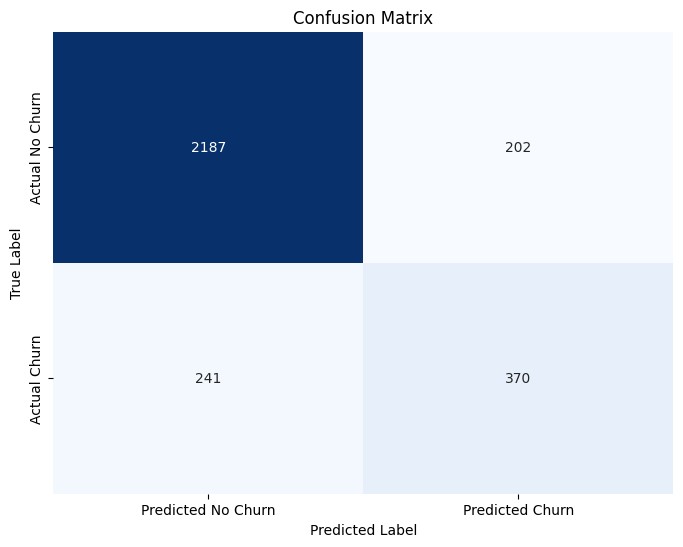

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix (assuming 'cm' is already defined from previous steps)
# If 'cm' was not defined, you would need to calculate it again:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [56]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.92 0.08]
 [0.39 0.61]]


In [54]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2389
           1       0.65      0.61      0.63       611

    accuracy                           0.85      3000
   macro avg       0.77      0.76      0.77      3000
weighted avg       0.85      0.85      0.85      3000



# Saving the model

In [63]:
from google.colab import files

# Assuming the model was saved as 'XGBoost_model.sav' in the current directory
# If you saved it in '../models/', you'll need to specify that path.
model_filename = 'XGBoost_model.sav'

try:
    files.download(model_filename)
    print(f"'{model_filename}' download initiated.")
except FileNotFoundError:
    print(f"Error: '{model_filename}' not found. Please ensure the file exists at the specified path.")
except Exception as e:
    print(f"An error occurred during download: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'XGBoost_model.sav' download initiated.


In [64]:
import joblib
import os

# Define the filename where the model was saved
model_filename = 'XGBoost_model.sav'

# Check if the file exists before attempting to load
if os.path.exists(model_filename):
    loaded_model = joblib.load(model_filename)
    print(f"Model '{model_filename}' loaded successfully.")
else:
    print(f"Error: Model file '{model_filename}' not found. Please ensure it is in the correct directory.")

Model 'XGBoost_model.sav' loaded successfully.


In [65]:
if 'loaded_model' in locals():
    print("Type of loaded_model:", type(loaded_model))
    print("Loaded model details:", loaded_model)
else:
    print("Model was not loaded or variable 'loaded_model' is not defined.")

Type of loaded_model: <class 'sklearn.model_selection._search.GridSearchCV'>
Loaded model details: GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                

In [66]:
# load the model
xgb_model = joblib.load(filename)
print(xgb_model.score(X_test, y_test))


0.766781181961393


# Predict class for new data

In [70]:
# Let's use the first X_test record as new data
X_test[:1]

array([[638, 'France', 'Male', 36, 6, 188455.19, 1, 0, 0, 47031.4]],
      dtype=object)

In [72]:
pred_new = xgb_model.predict(X_test[:1])

In [73]:
print(f"Predicted classes: \t{pred_new}")
print(f"Actual Labels: \t\t{list(y_test[:1])}")

Predicted classes: 	[0]
Actual Labels: 		[1]
